In [1]:
import glob
import os
import time
import numpy as np
import pandas as pd
import open3d as o3d
import trimesh
from trimesh.voxel import creation as tri_creation
from matplotlib import pyplot as plt
from shapely.geometry import MultiLineString, Point, LineString
from shapely.ops import unary_union, polygonize
import scipy
import scipy.io
from scipy.spatial import Delaunay, ConvexHull, distance_matrix
from scipy.spatial.transform import Rotation as RR
from collections import Counter
import itertools
import time
import cv2
import copy
import utils
from utils import computeRMSE, computeASSD, computeHD
import projection_utils as proj
import skimage
import enum
import h5py
import cycpd
import matlab.engine
from emopt5views_matlab_parallel_rotvec import EMOpt5Views, PHOTO

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [13]:
ENGINE = matlab.engine.connect_matlab()

In [2]:
SSM_DIR = r"./data/cpdGpAlignedData/eigValVec/"
CPD_ALIGNED_DIR = r"./data/cpdGpAlignedData/"
PARAM_DIR = r"./data/cpdGpParams/"

NUM_PC = 3
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
RGB_EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/RGB/"
SRC_DIR = r"./dataWithPhoto/cpdGpAlignedData/"
SRC_PARAM_DIR = r"./dataWithPhoto/cpdGpParams/"
PG_NPY = os.path.join(SRC_PARAM_DIR, "Y_pg.npy")
MASK_NPY = os.path.join(SRC_PARAM_DIR, "X_mask.npy")

MATLAB_PATH = r"./matlab_script"
# EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/"
EDGE_MASK_PATH = r"./dataWithPhoto/learning/fold5/test/pred/"
# STAGE0_MAT_DIR = os.path.join(MATLAB_PATH, "stage0-mat")
STAGE0_MAT_DIR = os.path.join(MATLAB_PATH, "stage0-mat-test")
# DEMO_H5_DIR = r"./dataWithPhoto/demo/"
DEMO_H5_DIR = r"./dataWithPhoto/demo-test/"
# DEMO_MESH_DIR = r"./dataWithPhoto/demoMesh/"
DEMO_MESH_DIR = r"./dataWithPhoto/demoMesh-test/"

name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)
# 顺序相互对应
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

In [3]:
TagID = 63

In [4]:
edgeMasks = proj.getEdgeMask(EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=800)
# edgeMasks = proj.getRgbEdgeMask(RGB_EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=800)

['./dataWithPhoto/learning/fold5/test/pred/安然_219474_上牙列.png', './dataWithPhoto/learning/fold5/test/pred/安然_219474_下牙列.png', './dataWithPhoto/learning/fold5/test/pred/安然_219474_左侧咬合.png', './dataWithPhoto/learning/fold5/test/pred/安然_219474_右侧咬合.png', './dataWithPhoto/learning/fold5/test/pred/安然_219474_正位像.png']


num of contour points in upperPhoto: 10569 
num of contour points in lowerPhoto: 8948 
num of contour points in leftPhoto: 8114 
num of contour points in rightPhoto: 7481 
num of contour points in frontalPhoto: 8300 


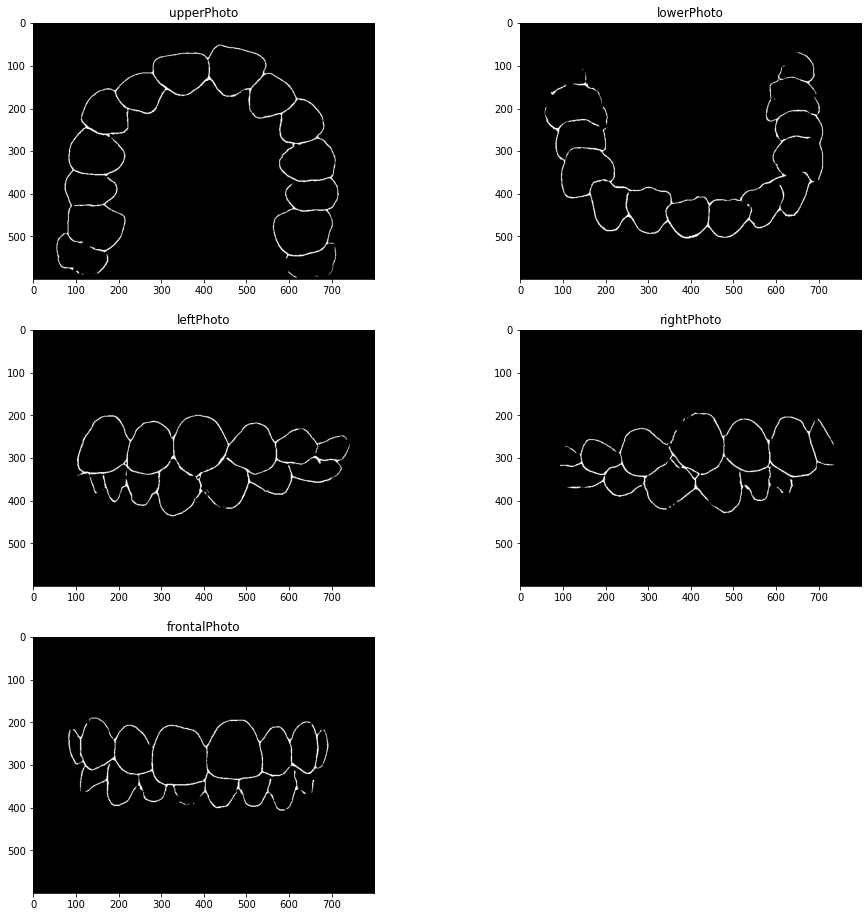

In [5]:
proj.visualizeEdgeMasks(edgeMasks, photo_types)

In [23]:
# # Run it only once
# utils.saveEigValVec(CPD_ALIGNED_DIR, NumPC2Save=100)

In [6]:
Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)

In [7]:
# # Run it only once
# src_invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=SRC_PARAM_DIR) # 加载待优化点云配准过程中的参数
# Y_pg, X_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec = proj.loadDataSet(src_invRegistrationParamDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR)
# np.save(PG_NPY, np.array(Y_pg))
# np.save(MASK_NPY, np.array(X_mask))

In [8]:
# reference pointcloud
Mask = proj.GetMaskByTagId(MASK_NPY, TagId=TagID)
PG_Ref = proj.GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref = PG_Ref[Mask]

In [9]:
invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=PARAM_DIR) # 加载建立SSM配准过程中的参数
invParamDF = proj.updateAbsTransVecs(invRegistrationParamDF, Mu) # 将牙列scale转化为每颗牙齿的位移，将每颗牙齿的transVecXYZs在局部坐标系下进行表达

invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars = proj.getMeanAndVarianceOfInvRegistrationParams(invParamDF)
scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotAngleStds = np.sqrt(invRotAngleXYZVars)
print("scaleStd: {:.4f}, transVecStd: {:.4f}, rotAngleStd: {:.4f}".format(scaleStds.mean(), transVecStds.mean(), rotAngleStds.mean()))

PoseCovMats = proj.GetPoseCovMats(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 每个位置的牙齿的6个变换参数的协方差矩阵,shape=(28,6,6)
ScaleCovMat = proj.GetScaleCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 牙齿scale的协方差矩阵,shape=(28,28)

scaleStd: 0.0665, transVecStd: 1.1844, rotAngleStd: 0.1391


## Optimization

In [10]:
# 初始化
photoTypes = [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
VISIBLE_MASKS = [proj.MASK_UPPER, proj.MASK_LOWER, proj.MASK_LEFT, proj.MASK_RIGHT, proj.MASK_FRONTAL]
emopt = EMOpt5Views(edgeMasks, photoTypes, VISIBLE_MASKS, Mask, Mu, SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStds.mean(), rotAngleStds.mean())

E_step_result_file = os.path.join(MATLAB_PATH, "E-step-result.mat")
M_step_result_file = os.path.join(MATLAB_PATH, "M-step-result.mat")

In [11]:
print("num of observed edge points: ", emopt.M)
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(emopt.X_trans, X_Ref)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(emopt.X_trans, X_Ref)))

num of observed edge points:  [10569, 8948, 8114, 7481, 8300]
ex_rxyz:  [[ 2.19911486  0.          0.        ]
 [-2.19911486  0.          0.        ]
 [ 2.8         0.         -1.42      ]
 [ 2.8         0.          1.42      ]
 [ 3.14159265  0.          0.        ]]
ex_txyz:  [[ 0.  0. 70.]
 [ 0.  0. 70.]
 [-5.  0. 70.]
 [ 5.  0. 70.]
 [ 0. -2. 70.]]
rela_rxyz:  [0. 0. 0.]
rela_txyz:  [ 0. -5.  0.]
focal length:  [50. 50. 35. 35. 35.]
d_pixel:  [0.06 0.06 0.06 0.06 0.06]
u0: [400. 400. 400. 400. 400.], v0: [300. 300. 300. 300. 300.]
[RMSE] Root Mean Squared Surface Distance(mm): 2.3826
[ASSD] average symmetric surface distance (mm): 1.0850
[HD] Hausdorff distance (mm): 2.7051


In [ ]:
emopt.searchDefaultRelativePoseParams()
emopt.gridSearchExtrinsicParams()

In [ ]:
emopt.gridSearchRelativePoseParams()

In [14]:
emopt.expectation_step_5Views(verbose=True)

PHOTO.UPPER - unique pred points: 910 - E-step loss: 90.65
PHOTO.LOWER - unique pred points: 787 - E-step loss: 134.15
PHOTO.LEFT - unique pred points: 548 - E-step loss: 193.37
PHOTO.RIGHT - unique pred points: 531 - E-step loss: 143.86
PHOTO.FRONTAL - unique pred points: 613 - E-step loss: 260.32


In [16]:
X = emopt.P_true[1].astype(np.double)
# X = utils.farthestPointDownSample(X, num_point_sampled=5000, return_flag=False)
tic = time.time()

Y = emopt.P_pred[1].astype(np.double)
# 二维相似变换配准
reg = cycpd.rigid_registration(**{'X': X, 'Y': Y, 'max_iterations':100,'tolerance':1.0, 'w':0.01, 'verbose':True,'print_reg_params':True})
TY,(s,r,t) = reg.register()
toc = time.time()

Iteration:1
ML:-12759.605; 	ML change (error): 12759.605; 	Sigma^2: 29276.614; 	Sigma^2 change: 39143.884
[                                                                        ]
Iteration:2
ML: -3168.053; 	ML change (error):  9591.552; 	Sigma^2: 22542.540; 	Sigma^2 change:  6734.074
[=                                                                       ]
Iteration:3
ML: -1198.478; 	ML change (error):  1969.574; 	Sigma^2: 16668.317; 	Sigma^2 change:  5874.223
[==                                                                      ]
Iteration:4
ML:  1718.075; 	ML change (error):  2916.553; 	Sigma^2: 11524.079; 	Sigma^2 change:  5144.238
[==                                                                      ]
Iteration:5
ML:  5065.305; 	ML change (error):  3347.230; 	Sigma^2:  7846.158; 	Sigma^2 change:  3677.921
[===                                                                     ]
Iteration:6
ML:  7932.958; 	ML change (error):  2867.653; 	Sigma^2:  5521.216; 	Sigma^2 change:

In [12]:
print(toc-tic)

6.3588902950286865


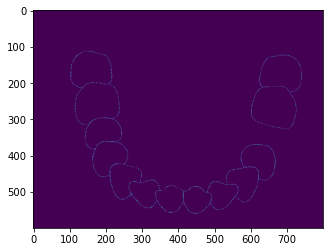

In [19]:
canvas = np.zeros(emopt.edgeMask[1].shape)
aligned_p_pred = TY.astype(np.int32)
canvas[aligned_p_pred[:,1], aligned_p_pred[:,0]] = 1.
plt.imshow(canvas)

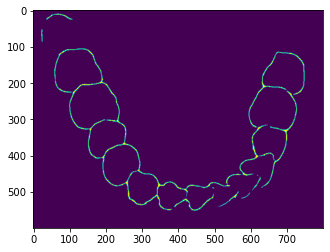

In [20]:
X = emopt.P_true[1].astype(np.double)
canvas2 = np.zeros(emopt.edgeMask[1].shape)
p_true = X.astype(np.int32)
canvas2[p_true[:,1],p_true[:,0]] = 1.
plt.imshow(canvas2)

In [15]:
stage0initMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage0-init-{}.mat".format(TagID))
# proj.saveTempEmOptParamsWithXRef(stage0initMatFile, emopt, X_Ref)

In [16]:
# Continue from checkpoint "E-step-result-stage0-init-ref.mat"

stage = 0
ENGINE.addpath(MATLAB_PATH)
ENGINE.run_MStep(stage, 500, stage0initMatFile, M_step_result_file, nargout=0)
emopt.load_maximization_step_result(M_step_result_file, stage)
emopt.expectation_step_5Views(verbose=True)
print("Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))

PHOTO.UPPER - unique pred points: 1177 - E-step loss: 33.54
PHOTO.LOWER - unique pred points: 905 - E-step loss: 38.82
PHOTO.LEFT - unique pred points: 777 - E-step loss: 10.54
PHOTO.RIGHT - unique pred points: 706 - E-step loss: 34.02
PHOTO.FRONTAL - unique pred points: 898 - E-step loss: 14.86
Root Mean Squared Surface Distance(mm): 2.3826


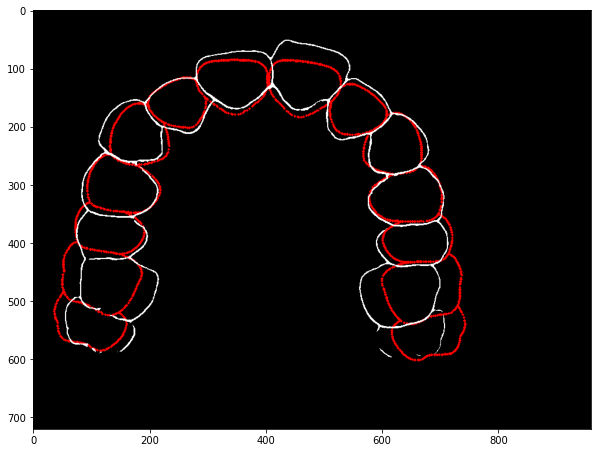

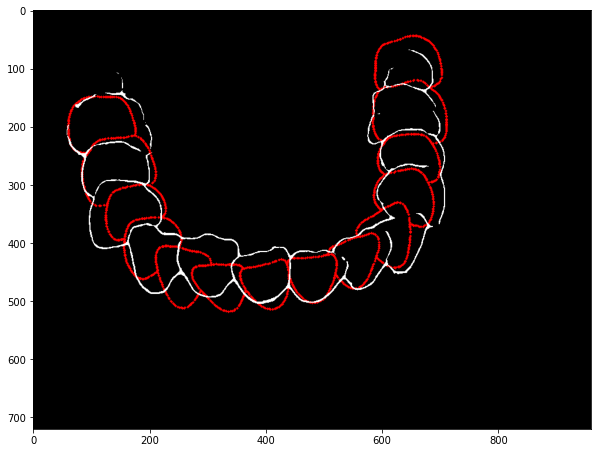

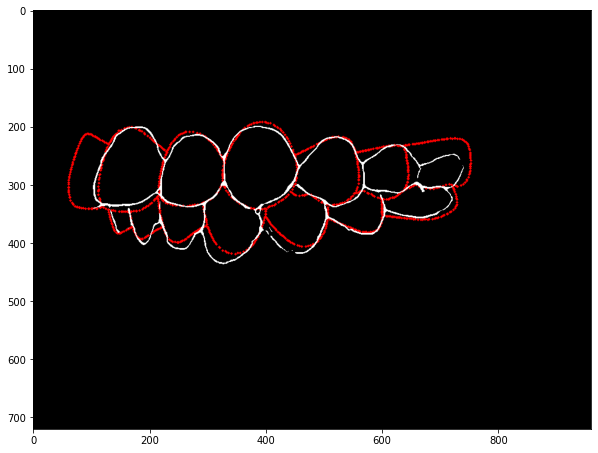

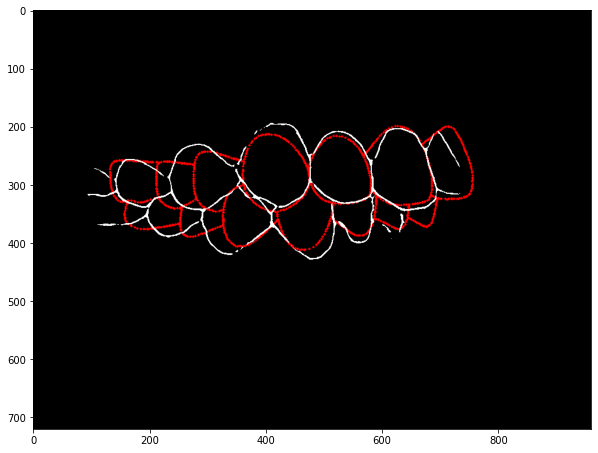

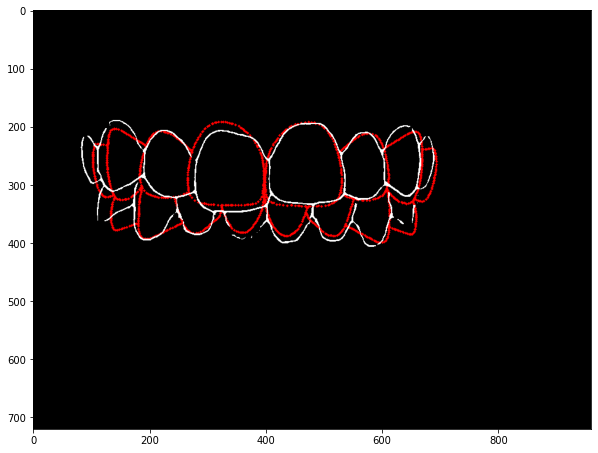

In [17]:
canvasShape = (720,960)
for photoType in photoTypes:
    emopt.showEdgeMaskPredictionWithGroundTruth(photoType, canvasShape, dilate=True)

In [ ]:
def MultiLines(canvas, lines, color, contourThickness=1):
    for line in lines:
        cv2.line(canvas, line[0], line[1], color, thickness=contourThickness)
    return canvas

In [ ]:
for phType in emopt.photoTypes:
    ph = phType.value
    P_true = emopt.P_true[ph].astype(np.int32)
    P_pred = emopt.P_pred[ph].astype(np.int32)
    corre_pred_idx = emopt.corre_pred_idx[ph]
    sampled_P_true, sampled_flag = utils.farthestPointDownSample(P_true, 3000, True)
    sampled_corre_pred_idx = corre_pred_idx[sampled_flag]
    sampled_P_corre_pred = P_pred[sampled_corre_pred_idx]
    line_segs = np.stack([sampled_P_true,sampled_P_corre_pred], axis=1)
    canvasShape=(720,960)
    canvas = emopt.showEdgeMaskPredictionWithGroundTruth(PHOTO(ph), canvasShape, dilate=True)
    canvas = (255.*canvas).astype(np.uint8)
    img = MultiLines(canvas, line_segs, (255,255,255), contourThickness=1)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

In [ ]:
stage = 0
maxFuncEval = 500
E_loss = []
for it in range(10):
    emopt.maximization_step_5Views_by_Matlab(MATLAB_PATH, ENGINE, stage, maxFuncEval)
    # emopt.maximization_step_5Views(stage, step=-1, rhobeg=1.0, maxiter=maxFuncEval, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        E_loss.append(e_loss)
        break
    else:
        E_loss.append(e_loss)

In [ ]:
stage0finalMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage0-final-{}.mat".format(TagID))
proj.saveTempEmOptParamsWithXRef(stage0finalMatFile, emopt, X_Ref)

In [ ]:
skipStage1Flag = False
# 判断条件1：是否跳过stage1
if E_loss[-1] > 500:
    skipStage1Flag = True

print("Start Stage 1.")

stage = 1
maxFuncEval = 800
for it in range(3):
    emopt.maximization_step_5Views_by_Matlab(MATLAB_PATH, ENGINE, stage, maxFuncEval)    
    # emopt.maximization_step_5Views(stage, step=-1, rhobeg=1.0, maxiter=maxFuncEval, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if e_loss >= E_loss[-1]: # len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        # 判断条件2：是否跳过stage1
        if it == 0:
            skipStage1Flag = True # first optimization with rowScaleXZ gets worse result compared with optimziaiton without rowScaleXZ
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)

In [ ]:
print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))

# 判断条件3：是否跳过stage1
_rowScaleX, _rowScaleZ = emopt.rowScaleXZ
_rowScaleDiff = np.abs(_rowScaleX - _rowScaleZ)
_minDiverge = np.abs(1. - emopt.rowScaleXZ).min()
if _minDiverge > 0.02 and _rowScaleDiff < _minDiverge:
    skipStage1Flag = True

In [ ]:
# 判断是否跳过stage1
if skipStage1Flag == True:
    print("Skip Stage 1; Reverse to Stage 0 final result.")
    # emopt.rowScaleXZ = np.array([1.,1.])
    emopt.rowScaleXYZ = np.array([1.,1.,1.])
    ENGINE.run_MStep(0, 500, stage0finalMatFile, M_step_result_file, nargout=0)
    emopt.load_maximization_step_result(M_step_result_file, 2)
    emopt.expectation_step_5Views(verbose=True)
else:
    print("Accept Stage 1.")
    emopt.anistropicRowScale2ScalesAndTransVecs()      
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

In [ ]:
stage2initMatFile = os.path.join(MATLAB_PATH, "E-step-result-stage2-init-ref.mat")
# proj.saveTempEmOptParamsWithXRef(stage2initMatFile, emopt, X_Ref)

In [ ]:
# Continue from checkpoint "E-step-result-stage2-init-ref.mat"

stage = 2
ENGINE.addpath(MATLAB_PATH)
ENGINE.run_MStep(stage, 1, stage2initMatFile, M_step_result_file, nargout=0)
emopt.load_maximization_step_result(M_step_result_file, stage)
emopt.expectation_step_5Views(verbose=True)
print("Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))

In [ ]:
# stage = 2
# maxFuncEval = 5000
# E_loss = []
# for it in range(10):
#     emopt.maximization_step_5Views_by_Matlab(MATLAB_PATH, eng, stage, maxFuncEval)
#     # print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
#     emopt.expectation_step_5Views(verbose=True)
#     e_loss = np.sum(emopt.weightViewMaxiStage2 * emopt.loss_expectation_step)
#     print("Sum of expectation step loss: {:.4f}".format(e_loss))
#     print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
#     if len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
#         print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
#         break
#     else:
#         E_loss.append(e_loss)

## Optimization Algorithm: COBYLA

In [ ]:
# E_loss = []
# for it in range(30):
#     emopt.maximization_stage1_step_5Views(rhobeg=1.0, maxiter=1000, verbose=False)
#     print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
#     emopt.expectation_step_5Views(verbose=True)
#     e_loss = np.sum(emopt.weightViewMaxiStage1 * emopt.loss_expectation_step)
#     print("Sum of expectation step loss: {:.4f}".format(e_loss))
#     print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
#     if len(E_loss)>=2 and (e_loss>=np.mean(E_loss[-2:])):
#         print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
#         break
#     else:
#         E_loss.append(e_loss)

In [ ]:
# print("emopt.rela_txyz: ", emopt.rela_txyz)
# print("emopt.rela_rxyz: ", emopt.rela_rxyz)
# print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
# print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))
# emopt.anistropicRowScale2ScalesAndTransVecs()
# print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
# print("transVecStd: {:.4f}, rotAngleStd: {:.4f}, scaleStd: {:.4f}".format(emopt.transVecStd, emopt.rotAngleStd, emopt.scaleStd))

In [ ]:
print("Start Stage 2.")
stage = 2
E_loss = []
for it in range(3):
    
    
    emopt.maximization_step_5Views(stage, step=2, rhobeg=0.1, maxiter=1000, verbose=False)
    emopt.maximization_step_5Views(stage, step=3, rhobeg=0.1, maxiter=1000, verbose=False)
    emopt.maximization_step_5Views(stage=3, step=-1, rhobeg=0.1, maxiter=1000, verbose=False)
    emopt.maximization_step_5Views(stage, step=1, rhobeg=0.1, maxiter=1000, verbose=False)
    
    
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and (e_loss>=np.mean(E_loss[-2:])):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)

In [ ]:
emopt.featureVec

In [ ]:
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(X_Ref, emopt.X_trans)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(X_Ref, emopt.X_trans)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(X_Ref, emopt.X_trans)))

In [ ]:
canvasShape = (720,960)
for photoType in photoTypes:
    emopt.showEdgeMaskPredictionWithGroundTruth(photoType, canvasShape, dilate=True)

In [ ]:
# for it in range(5):
#     emopt.expectation_step_5Views(verbose=True)
#     emopt.maximization_stage3_step(verbose=True)
#     print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

In [ ]:
invRotAngleXYZVars = invRotAngleXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[Mask]))
print("standard rotAngleXYZs:")
print((emopt.rotAngleXYZs - emopt.meanRotAngleXYZs) / np.sqrt(invRotAngleXYZVars[Mask]))
print("scales:")
print(emopt.scales)

In [ ]:
emopt.rela_txyz

In [ ]:
# 均值牙列模型
# proj.showPredPointClouds(y=X_Ref[:emopt.numUpperTooth].reshape(-1,3),py=emopt.X_Mu[:emopt.numUpperTooth].reshape(-1,3))
# proj.showPredPointClouds(y=X_Ref[emopt.numUpperTooth:].reshape(-1,3),py=emopt.X_Mu[emopt.numUpperTooth:].reshape(-1,3))

In [ ]:
# 优化后对比
proj.showPredPointClouds(y=X_Ref[:emopt.numUpperTooth].reshape(-1,3),py=(emopt.X_trans[:emopt.numUpperTooth]).reshape(-1,3))
proj.showPredPointClouds(y=X_Ref[emopt.numUpperTooth:].reshape(-1,3),py=(emopt.X_trans[emopt.numUpperTooth:]).reshape(-1,3))

In [ ]:
# 不考虑第二磨牙
withoutSecondMolarMask = np.tile(np.array([1,1,1,1,1,1,0],dtype=np.bool_),(4,))
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans[withoutSecondMolarMask[Mask]], X_Ref[withoutSecondMolarMask[Mask]])))

In [20]:
# 上下牙列不同的相对位移对应的位置可视化
rela_txyz = np.array([0.,-4.,0.])
Xtrans = np.concatenate([emopt.X_trans[:emopt.numUpperTooth], np.matmul(emopt.X_trans[emopt.numUpperTooth:],emopt.rela_R)+rela_txyz], axis=0)
utils.showPointCloud(Xtrans.reshape(-1,3), "")

## Save Demo Result

In [ ]:
demoH5File = r"./dataWithPhoto/demo/demo_TagID={}.h5".format(TagID)
proj.saveDemo2H5(demoH5File, emopt, TagID, X_Ref)

In [ ]:
patientID = 47
demoH5File2Load = r"./dataWithPhoto/demo/demo_TagID={}.h5".format(patientID)
X_Mu_Upper, X_Mu_Lower, X_Pred_Upper, X_Pred_Lower, X_Ref_Upper, X_Ref_Lower, rela_R, rela_t = proj.readDemoFromH5(demoH5File2Load, patientID)
_X_Ref = np.concatenate([X_Ref_Upper,X_Ref_Lower])
_X_Mu = np.concatenate([X_Mu_Upper,X_Mu_Lower])
_X_Pred = np.concatenate([X_Pred_Upper,X_Pred_Lower])

In [ ]:
# 牙列均值与Ground Truth对比
# proj.showPredPointClouds(y=X_Ref_Upper.reshape(-1,3),py=X_Mu_Upper.reshape(-1,3),mode=2)
# proj.showPredPointClouds(y=X_Ref_Lower.reshape(-1,3),py=X_Mu_Lower.reshape(-1,3),mode=3)
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(_X_Ref, _X_Mu)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(_X_Ref, _X_Mu)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(_X_Ref, _X_Mu)))

In [ ]:
# 牙列预测与Ground Truth对比
proj.showPredPointClouds(y=X_Ref_Upper.reshape(-1,3),py=X_Pred_Upper.reshape(-1,3),mode=2)
proj.showPredPointClouds(y=X_Ref_Lower.reshape(-1,3),py=X_Pred_Lower.reshape(-1,3),mode=3)

In [ ]:
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(_X_Ref, _X_Pred)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(_X_Ref, _X_Pred)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(_X_Ref, _X_Pred)))

In [ ]:
with_scale = True
T_Upper = utils.computeTransMatByCorres(X_Pred_Upper.reshape(-1,3), X_Ref_Upper.reshape(-1,3), with_scale=with_scale)
T_Lower = utils.computeTransMatByCorres(X_Pred_Lower.reshape(-1,3), X_Ref_Lower.reshape(-1,3), with_scale=with_scale)

TX_Pred_Upper = np.matmul(X_Pred_Upper, T_Upper[:3,:3]) + T_Upper[3,:3]
TX_Pred_Lower = np.matmul(X_Pred_Lower, T_Lower[:3,:3]) + T_Lower[3,:3]
_TX_Pred = np.concatenate([TX_Pred_Upper, TX_Pred_Lower])

In [ ]:
# 牙列预测经过相似变换后与Ground Truth对比
proj.showPredPointClouds(y=X_Ref_Upper.reshape(-1,3),py=TX_Pred_Upper.reshape(-1,3),mode=2)
proj.showPredPointClouds(y=X_Ref_Lower.reshape(-1,3),py=TX_Pred_Lower.reshape(-1,3),mode=3)

In [ ]:
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(_X_Ref, _TX_Pred)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(_X_Ref, _TX_Pred)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(_X_Ref, _TX_Pred)))

In [ ]:
X_Ref_Upper_Meshes = [utils.surfaceVertices2WatertightO3dMesh(pg) for pg in X_Ref_Upper]
X_Ref_Lower_Meshes = [utils.surfaceVertices2WatertightO3dMesh(pg) for pg in X_Ref_Lower]
Ref_Upper_Mesh = utils.mergeO3dTriangleMeshes(X_Ref_Upper_Meshes)
Ref_Lower_Mesh = utils.mergeO3dTriangleMeshes(X_Ref_Lower_Meshes)

In [ ]:
TX_Pred_Upper_Meshes = [utils.surfaceVertices2WatertightO3dMesh(pg) for pg in TX_Pred_Upper]
TX_Pred_Lower_Meshes = [utils.surfaceVertices2WatertightO3dMesh(pg) for pg in TX_Pred_Lower]
Aligned_Pred_Upper_Mesh = utils.mergeO3dTriangleMeshes(TX_Pred_Upper_Meshes)
Aligned_Pred_Lower_Mesh = utils.mergeO3dTriangleMeshes(TX_Pred_Lower_Meshes)

In [ ]:
demoMeshDir = r"./dataWithPhoto/demoMesh/{}/".format(patientID)
if not os.path.exists(demoMeshDir):
    os.makedirs(demoMeshDir)
utils.exportTriMeshObj(np.asarray(Ref_Upper_Mesh.vertices), np.asarray(Ref_Upper_Mesh.triangles), \
                       os.path.join(demoMeshDir,"Ref_Upper_Mesh_TagID={}.obj".format(patientID)))
utils.exportTriMeshObj(np.asarray(Ref_Lower_Mesh.vertices), np.asarray(Ref_Lower_Mesh.triangles), \
                       os.path.join(demoMeshDir,"Ref_Lower_Mesh_TagID={}.obj".format(patientID)))
utils.exportTriMeshObj(np.asarray(Aligned_Pred_Upper_Mesh.vertices), np.asarray(Aligned_Pred_Upper_Mesh.triangles), \
                       os.path.join(demoMeshDir,"Aligned_Pred_Upper_Mesh_TagID={}.obj".format(patientID)))
utils.exportTriMeshObj(np.asarray(Aligned_Pred_Lower_Mesh.vertices), np.asarray(Aligned_Pred_Lower_Mesh.triangles), \
                       os.path.join(demoMeshDir,"Aligned_Pred_Lower_Mesh_TagID={}.obj".format(patientID)))

In [ ]:
Dice_VOE_lst = [utils.computeDiceAndVOE(_x_ref, _x_pred, pitch=0.2) for _x_ref, _x_pred in zip(_X_Ref, _TX_Pred)]

In [ ]:
for _x_pred in _TX_Pred:
    utils.surfaceVertices2WatertightO3dMesh( _x_pred, showInWindow=True)

In [ ]:
avg_Dice, avg_VOE = np.array(Dice_VOE_lst).mean(axis=0)
print("[DC] Volume Dice Coefficient: {:.4f}".format(avg_Dice))
print("[VOE] Volumetric Overlap Error: {:.2f} %".format(100.*avg_VOE))

In [ ]:
# 上下牙列咬合时的相对位置的预测
X_assem = np.concatenate([X_Pred_Upper, np.matmul(X_Pred_Lower, rela_R)+rela_t], axis=0)
utils.showPointCloud(X_assem.reshape(-1,3), "上下牙列咬合时的相对位置关系的预测")

## Validation: 验证忽略rowScale后的transVec是否正确

In [ ]:
sample = invParamDF[invParamDF["tag"]==TagID]
toothIndices = UPPER_INDICES+LOWER_INDICES
invScalesColumns = ["{}s".format(id) for id in toothIndices]
invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]

In [ ]:
scales = sample[invScalesColumns].to_numpy().reshape((28,))
rotAngles = sample[invRotAngleXYZColumns].to_numpy().reshape((28,3))
transVecs = sample[invTransVecXYZColumns].to_numpy().reshape((28,3))
isp = 14
scales = scales[:isp][Mask[:isp]]
rotAngles = rotAngles[:isp][Mask[:isp]]
rotMats = np.array([utils.getRotMat(rxyz) for rxyz in rotAngles])
transVecs = transVecs[:isp][Mask[:isp]]
mu = Mu[:isp][Mask[:isp]]

In [ ]:
pg = scales[:,None,None] * np.matmul((mu-mu.mean(axis=1,keepdims=True)), rotMats) + transVecs[:,None,:] + mu.mean(axis=1,keepdims=True)

In [ ]:
ssaPath = "./data/ssa-repaired-txt/"
PGs = []
for tID in toothIndices:
    fp = os.path.join(ssaPath,str(tID),"{}U.txt".format(TagID))
    if os.path.exists(fp):
        x = np.loadtxt(fp)
        PGs.append(x)

In [ ]:
ref_pgs = np.vstack(PGs)
initTransVecShifts = invRegistrationParamDF[invRegistrationParamDF["tag"]==TagID]["upper_ts"].values[0]
pg = pg + initTransVecShifts[:,None,:]

In [ ]:
proj.showPredPointClouds(y=ref_pgs,py=(pg).reshape(-1,3))